In [2]:
import sys
sys.path.insert(0,'python')
from classification import *
import pylab as plt
from fastRWpkl import *
from readSent import *
from scipy.ndimage.morphology import binary_dilation as bd
import scipy.ndimage as ndimage
import cPickle as pkl
import numpy as np
import scipy
from scipy import signal
from functools import partial
import multiprocessing
import numpy.ma as ma
from collections import Counter
import cPickle as pkl
import pylab as plt
from scipy.fftpack import dct, idct
import scipy.stats
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from scipy import optimize
import matplotlib.patches as patches
from geo_trans import *
%matplotlib inline

In [3]:
modis_sent = parallel_rw_pkl(None,'patch15MS','r')
patch15Sen = parallel_rw_pkl(None, 'patch15Sen', 'r')

cm = parallel_rw_pkl(None, '0510diacm', 'r')[1000:2000,5000:6000]
Sindex = parallel_rw_pkl(None, 'Sindex', 'r')
centers = Sindex

In [15]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p,winsize, sen_cut, modis_sen):    
    xstd,ystd,angle, sx, sy = p
    xwin,ywin = winsize, winsize
    
    to_regression =[]          
    
    for ii,cx in enumerate(patchx):
        cy = patchy[ii] - j*1000
        cx -= i*1000
        hfwin = winsize/2
        minx = cx+sx - hfwin
        maxx = cx+sx + hfwin
        miny = cy+sy - hfwin
        maxy = cy+sy + hfwin

        to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
        brdf = modis_sen[cx,cy]*0.001

        if (to_conv.shape[0]==winsize) & (to_conv.shape[1]==winsize) & (brdf!=np.nan):
            To_conv = to_conv
            Brdf = brdf
            nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
            To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
            gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
            ker = gaus/(gaus.sum())

            s = signal.fftconvolve(To_conv, ker, mode='valid')
            to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    return costs

In [17]:
i, j = 1,5
#modis_cut = modis_sent[s1,s2]*0.001
in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]

p = np.array([29.696923, 339.96191637, 45.8861022468, -21.8540896067 , 60.2630764605])
costs = []
for ii in xrange(10,1000, 10):
    for jj in xrange(7):
        co = cost(p, ii, patch15Sen[jj], modis_sent[jj])
        costs.append([ii, jj, co])

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:37: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


costs: 0.121090469409 rvalue:  0.878909530591 slop:  0.916745830066 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 0.125598703216 rvalue:  0.874401296784 slop:  0.922214124023 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 0.155708568817 rvalue:  0.844291431183 slop:  0.753157102978 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 0.233268851143 rvalue:  0.766731148857 slop:  0.574667636569 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 0.226623459194 rvalue:  0.773376540806 slop:  0.509639489916 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 0.238979353478 rvalue:  0.761020646522 slop:  0.530212611801 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 0.23183807964 rvalue:  0.76816192036 slop:  0.62177177947

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:93: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:95: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:97: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


costs: 1.0 rvalue:  0.0 slop:  nan 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 1.0 rvalue:  0.0 slop:  nan 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 1.0 rvalue:  0.0 slop:  nan 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 1.0 rvalue:  0.0 slop:  nan 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 1.0 rvalue:  0.0 slop:  nan 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 1.0 rvalue:  0.0 slop:  nan 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 1.0 rvalue:  0.0 slop:  nan 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 1.0 rvalue:  0.0 slop:  nan 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 1.0 rvalu

ValueError: need more than 0 values to unpack

In [32]:
ar_cost = np.array(costs).reshape((98, 7,3))

In [52]:
ar_cost[:,i,:].T[2]

array([ 0.23183808,  0.18554094,  0.1473134 ,  0.11646057,  0.08805506,
        0.06981918,  0.05394339,  0.04679166,  0.0412743 ,  0.03702059,
        0.03690422,  0.03598796,  0.03833969,  0.04023805,  0.04578293,
        0.04692746,  0.04910476,  0.05423849,  0.0523922 ,  0.05606011,
        0.05911777,  0.06471647,  0.06742737,  0.07385261,  0.07931719,
        0.08348736,  0.09238675,  0.10299496,  0.10928569,  0.11741675,
        0.12307184,  0.13650083,  0.1415256 ,  0.15418238,  0.16317399,
        0.17036219,  0.18233486,  0.1884847 ,  0.20981709,  0.22102442,
        0.24501472,  0.25533971,  0.2828065 ,  0.28098806,  0.28709937,
        0.30155096,  0.3378614 ,  0.35813276,  0.37745771,  0.41310387,
        0.42325447,  0.41386211,  0.42868987,  0.44583881,  0.46315328,
        0.53121887,  0.53520878,  0.57109869,  0.58842071,  0.6073695 ,
        0.64454163,  0.59250543,  0.6208701 ,  0.59901897,  0.63598787,
        0.61818711,  0.69879751,  0.71047951,  0.65757746,  0.77

<function matplotlib.pyplot.tight_layout>

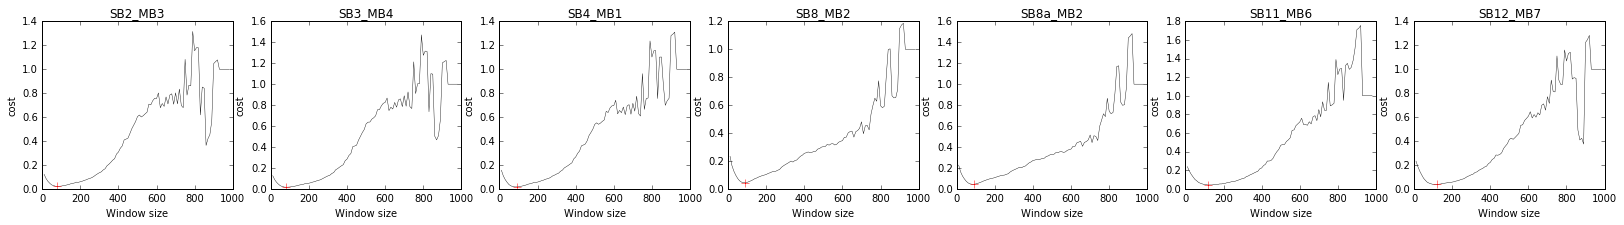

In [97]:
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')
plt.figure(figsize=(28,3))
for i in range(7):
    ax = plt.subplot(1,7,i+1)
    plt.plot(ar_cost[:,i,:].T[0], ar_cost[:,i,:].T[2], 'k-', linewidth=0.4)
    minval = ar_cost[:,i,:].T[2].min()
    x_ =  ar_cost[:,i,:].T[0][ar_cost[:,i,:].T[2]==minval]
    plt.plot(x_, minval, 'r+', markersize=8)
    plt.title('%s'%names[i])
    plt.xlabel('Window size')
    plt.ylabel('cost')
plt.tight_layout

In [191]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p,winsize):    
    xstd,ystd,angle, xs, ys = p
    xwin,ywin = winsize, winsize
    
    to_regression =[]          
    
    
    cx = centers[0]
    cy = centers[1]
    
    
    gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
    ker = gaus/(gaus.sum())

    s = signal.fftconvolve(sent, ker, mode='same')
    
    vld_x = ((cx+xs)>50)&((cx+xs)<9950)
    vld_y = ((cy+ys)>50)&((cy+ys)<9950)
    vld = vld_x&vld_y
    
    brdf = modis_sent[cx[vld],cy[vld]]*0.001
    indx,indy = np.round((cx+xs)[vld]).astype(int), np.round((cy+ys)[vld]).astype(int)
    vals = s[indx,indy]
    
    x,y = vals, brdf
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    return costs

In [192]:
p = np.array([29.696923, 339.96191637, 45.8861022468, -21.8540896067 , 60.2630764605])
psolve = optimize.fmin(cost,p,full_output=1, args=(100,), maxiter=10000, maxfun=10000)

costs: 0.0569408162867 rvalue:  0.943059183713 slop:  0.975997162953 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 0.0565949591673 rvalue:  0.943405040833 slop:  0.977291718979 
parameters:  [  31.18176915  339.96191637   45.88610225  -21.85408961   60.26307646] 

costs: 0.0569437113317 rvalue:  0.943056288668 slop:  0.976000538195 
parameters:  [  29.696923    356.96001219   45.88610225  -21.85408961   60.26307646] 

costs: 0.0570450009357 rvalue:  0.942954999064 slop:  0.975892145657 
parameters:  [  29.696923    339.96191637   48.18040736  -21.85408961   60.26307646] 

costs: 0.0575959164688 rvalue:  0.942404083531 slop:  0.975339823349 
parameters:  [  29.696923    339.96191637   45.88610225  -22.94679409   60.26307646] 

costs: 0.0540918066849 rvalue:  0.945908193315 slop:  0.978941406075 
parameters:  [  29.696923    339.96191637   45.88610225  -21.85408961   63.27623028] 

costs: 0.0552638635426 rvalue:  0.944736136457 slop:  0.97

KeyboardInterrupt: 

In [171]:
sent = readfile([12,],fhead)['B12']

data/50SMG20165100auxiliaryECMWFT
data/50SMG20165100metadata.xml


In [172]:
data = parallel_rw_pkl(None, 'inter_sent%i'%5, 'r')
mask = parallel_rw_pkl(None, 'inter_sentm%i'%5, 'r')

In [173]:
data[mask] = np.nan
modis_sent = np.array(data)

In [ ]:
sent = ScaleExtent(sent, (10980,10980))
cm = parallel_rw_pkl(None, 'newcloudm', 'r')

In [182]:
sent[cm] = sent[~cm].mean()

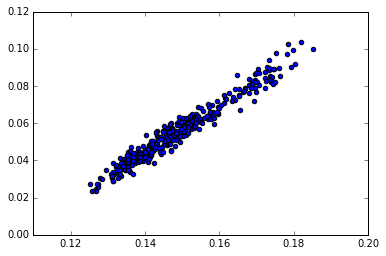

In [162]:
plt.scatter(x,y)

In [109]:
i,j=1,5
in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]

In [81]:
gaus = gaussian(100,100,20,300,45,False)                              
ker = gaus/(gaus.sum())
s = signal.fftconvolve(patch15Sen[0], ker, mode='same')

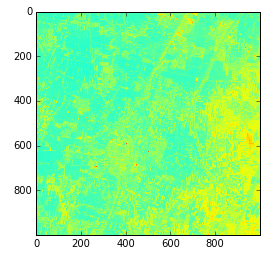

In [82]:
plt.imshow(patch15Sen[0], vmin=0, vmax=0.3)

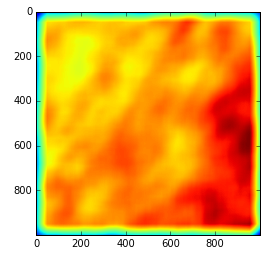

In [84]:
plt.imshow(s)

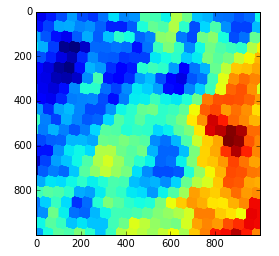

In [76]:
plt.imshow(modis_sent[0])